In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
#set hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 100

In [3]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [4]:
class Cifar10Model(nn.Module):
    def __init__(self, input_size=3*32*32, num_classes=10):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)#else xb.reshape(-1, 3*32*32)
        out = self.linear(xb)
        #out = F.softmax(out, dim=1)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)           # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)          # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = Cifar10Model()

In [5]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [6]:
dataset = torchvision.datasets.CIFAR10(root='../Data/data/', train=True, transform=transforms.ToTensor(), download=False)

train_ds, val_ds = random_split(dataset, [40000, 10000])
test_ds = torchvision.datasets.CIFAR10(root='../Data/data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

In [7]:
evaluate(model, val_loader)

{'val_loss': 2.357714891433716, 'val_acc': 0.11884765326976776}

In [8]:
history = fit(epochs=num_epochs, lr=learning_rate, model=model, train_loader=train_loader, val_loader=val_loader)

Epoch [0], val_loss: 2.1398, val_acc: 0.2578
Epoch [1], val_loss: 2.0664, val_acc: 0.2896
Epoch [2], val_loss: 2.0212, val_acc: 0.3092
Epoch [3], val_loss: 1.9906, val_acc: 0.3270
Epoch [4], val_loss: 1.9686, val_acc: 0.3279
Epoch [5], val_loss: 1.9492, val_acc: 0.3356
Epoch [6], val_loss: 1.9340, val_acc: 0.3423
Epoch [7], val_loss: 1.9231, val_acc: 0.3458
Epoch [8], val_loss: 1.9102, val_acc: 0.3501
Epoch [9], val_loss: 1.9017, val_acc: 0.3546
Epoch [10], val_loss: 1.8932, val_acc: 0.3537
Epoch [11], val_loss: 1.8856, val_acc: 0.3581
Epoch [12], val_loss: 1.8817, val_acc: 0.3558
Epoch [13], val_loss: 1.8733, val_acc: 0.3613
Epoch [14], val_loss: 1.8699, val_acc: 0.3582
Epoch [15], val_loss: 1.8630, val_acc: 0.3660
Epoch [16], val_loss: 1.8614, val_acc: 0.3660
Epoch [17], val_loss: 1.8548, val_acc: 0.3648
Epoch [18], val_loss: 1.8535, val_acc: 0.3673
Epoch [19], val_loss: 1.8492, val_acc: 0.3705
Epoch [20], val_loss: 1.8463, val_acc: 0.3707
Epoch [21], val_loss: 1.8424, val_acc: 0.374

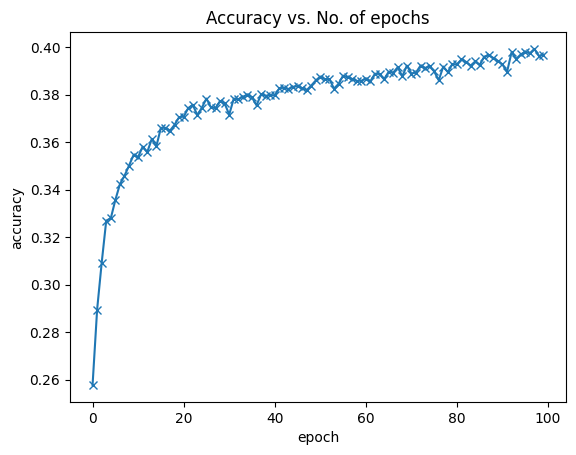

In [9]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [10]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 1.7577565908432007, 'val_acc': 0.38935548067092896}